In [1]:
import numpy as np
import pandas as pd
import torch
import openslide
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

from dataset import WSI_tiles

In [2]:
# Determine the device to run the model on (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load the model and its transformer

In [3]:
# # Create the model
# model = timm.create_model("hf-hub:bioptimus/H-optimus-0", pretrained=True, init_values=1e-5, dynamic_img_size=False)

# Load the whole model
model = torch.load("H-Optimus-0.pth", map_location=device, weights_only=False)

# Put the model on the device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Create the transform function from the model configuration
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.707223, 0.578729, 0.703617), 
        std=(0.211883, 0.230117, 0.177517)
    ),
])

# Open the slide using openslide

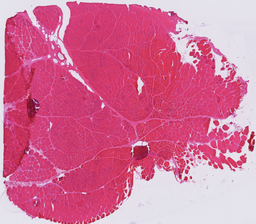

In [4]:
# Determine the slide id
slide_name = "Rome_1216-186-93_DGK_CAPN3 - 2024-12-18 15_4352_30208"

# Load the slide with openslide
slide = openslide.OpenSlide(f"/workspaces/WSI-Classification/data/HE-MYO/Processed/Dystrophic/{slide_name}.ome.tiff")

# Make a thumbnail of the slide
slide.get_thumbnail(size=(256, 256))

In [5]:
# Calculate tile centers for 448x448 tiles without intersection
tile_size = 448
slide_width, slide_height = slide.dimensions
x_coords, y_coords = [], []
for y in range(tile_size//2, slide_height, tile_size):
    for x in range(tile_size//2, slide_width, tile_size):
        x_coords.append(x)
        y_coords.append(y)

# Create DataFrame with id, x, and y columns
tiles = pd.DataFrame({'id': range(len(x_coords)), 'x': x_coords, 'y': y_coords})

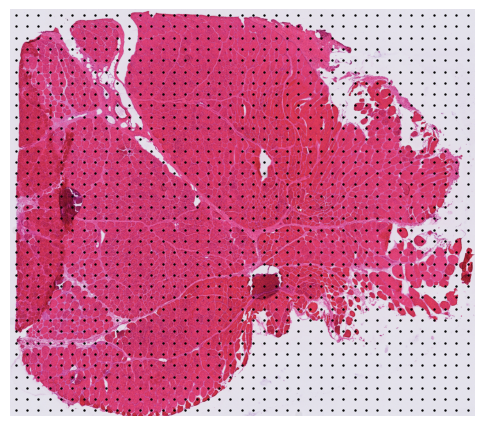

In [6]:
img = slide.read_region((0, 0), 0, slide.dimensions).convert("RGB")
img = np.array(img)[::10, ::10, :]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tiles['x']/10, tiles['y']/10, s=0.5, c='black')
ax.imshow(img)
ax.set_axis_off()
plt.show()

# Create the dataset

In [7]:
# Create the dataset
dataset = WSI_tiles(slide=slide,
                    tiles=tiles,
                    transform=transform,
                    size=(448, 448))

# Create the dataloader
dataloader = DataLoader(dataset,
                        batch_size=64,
                        shuffle=False)

# Perform inference on the dataset

In [8]:
# Create the embedding
feature_emb = []

# Iterate over the dataloader with tqdm
for batch in tqdm(dataloader, desc="Processing batches"):
    
    # Get the embedding from the model
    with torch.inference_mode():
        output = model(batch.to(device))
    
    # Append the embedding to the list
    feature_emb.append(output.cpu().numpy())

# Concatenate the embeddings
feature_emb = np.concatenate(feature_emb)

# Transform the embedding features into a dataframe
feature_emb_df = pd.DataFrame(feature_emb, index=tiles.index)

Processing batches: 100%|██████████| 24/24 [02:22<00:00,  5.94s/it]


In [9]:
# Clean up the GPU memory
torch.cuda.empty_cache()

# Save the Results

In [10]:
# Save the pixels
tiles.to_pickle(f"/workspaces/WSI-Classification/data/HE-MYO/Processed/Dystrophic/{slide_name}_tiles.pkl")

# Save the embedding features to a pickle file
feature_emb_df.to_pickle(f"/workspaces/WSI-Classification/data/HE-MYO/Processed/Dystrophic/{slide_name}_features.pkl")